In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

c:\users\lord sanmilee\appdata\local\programs\python\python36\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\users\lord sanmilee\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
c:\users\lord sanmilee\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


In [2]:
K.set_image_dim_ordering('th')

np.random.seed(1000)

# The input dimensionality is 100
randomDim = 100

# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)

# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

generator = Sequential()
generator.add(Dense(256, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [5]:
# Combined network of generator & discriminator

discriminator.trainable = False
ganInput = Input(shape=(randomDim,))

x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)


generator.summary()
print("\n \n")

discriminator.summary()
print("\n \n")

gan.summary()
print("\n \n")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               803600    
Total para

In [4]:
dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/gan_loss_epoch_%d.png' % epoch)
    
    
# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

    
# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('models/gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/gan_discriminator_epoch_%d.h5' % epoch)

In [5]:
def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] // batchSize
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batchCount)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 20 == 0:
            plotGeneratedImages(e)
            saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)


Epochs: 200
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 90.82it/s]


--------------- Epoch 2 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 91.35it/s]


--------------- Epoch 3 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 91.86it/s]


--------------- Epoch 4 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.15it/s]


--------------- Epoch 5 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 91.75it/s]


--------------- Epoch 6 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 91.58it/s]


--------------- Epoch 7 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.09it/s]


--------------- Epoch 8 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.93it/s]


--------------- Epoch 9 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 91.44it/s]


--------------- Epoch 10 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 87.92it/s]


--------------- Epoch 11 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.60it/s]


--------------- Epoch 12 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.74it/s]


--------------- Epoch 13 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 96.85it/s]


--------------- Epoch 14 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 90.47it/s]


--------------- Epoch 15 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 93.83it/s]


--------------- Epoch 16 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 86.04it/s]


--------------- Epoch 17 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 90.52it/s]


--------------- Epoch 18 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 98.76it/s]


--------------- Epoch 19 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 96.67it/s]


--------------- Epoch 20 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 98.63it/s]


--------------- Epoch 21 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 89.90it/s]


--------------- Epoch 22 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 88.14it/s]


--------------- Epoch 23 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 97.61it/s]


--------------- Epoch 24 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 98.15it/s]


--------------- Epoch 25 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 96.34it/s]


--------------- Epoch 26 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 98.15it/s]


--------------- Epoch 27 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 98.29it/s]


--------------- Epoch 28 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 98.24it/s]


--------------- Epoch 29 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 98.33it/s]


--------------- Epoch 30 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 98.40it/s]


--------------- Epoch 31 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 91.72it/s]


--------------- Epoch 32 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.12it/s]


--------------- Epoch 33 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 96.12it/s]


--------------- Epoch 34 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 90.44it/s]


--------------- Epoch 35 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.16it/s]


--------------- Epoch 36 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.14it/s]


--------------- Epoch 37 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 91.38it/s]


--------------- Epoch 38 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.78it/s]


--------------- Epoch 39 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 95.14it/s]


--------------- Epoch 40 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 95.42it/s]


--------------- Epoch 41 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 91.53it/s]


--------------- Epoch 42 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.45it/s]


--------------- Epoch 43 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.13it/s]


--------------- Epoch 44 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.10it/s]


--------------- Epoch 45 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.96it/s]


--------------- Epoch 46 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.60it/s]


--------------- Epoch 47 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.44it/s]


--------------- Epoch 48 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 95.31it/s]


--------------- Epoch 49 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.67it/s]


--------------- Epoch 50 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.33it/s]


--------------- Epoch 51 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.24it/s]


--------------- Epoch 52 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 90.92it/s]


--------------- Epoch 53 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 91.98it/s]


--------------- Epoch 54 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.06it/s]


--------------- Epoch 55 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 95.14it/s]


--------------- Epoch 56 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.32it/s]


--------------- Epoch 57 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.47it/s]


--------------- Epoch 58 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.06it/s]


--------------- Epoch 59 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 95.42it/s]


--------------- Epoch 60 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 95.32it/s]


--------------- Epoch 61 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 90.42it/s]


--------------- Epoch 62 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.33it/s]


--------------- Epoch 63 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 91.95it/s]


--------------- Epoch 64 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.38it/s]


--------------- Epoch 65 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.70it/s]


--------------- Epoch 66 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.67it/s]


--------------- Epoch 67 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.57it/s]


--------------- Epoch 68 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.20it/s]


--------------- Epoch 69 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.86it/s]


--------------- Epoch 70 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.72it/s]


--------------- Epoch 71 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.80it/s]


--------------- Epoch 72 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.65it/s]


--------------- Epoch 73 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.90it/s]


--------------- Epoch 74 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.78it/s]


--------------- Epoch 75 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.88it/s]


--------------- Epoch 76 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.50it/s]


--------------- Epoch 77 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.57it/s]


--------------- Epoch 78 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 95.00it/s]


--------------- Epoch 79 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.79it/s]


--------------- Epoch 80 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.99it/s]


--------------- Epoch 81 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 91.22it/s]


--------------- Epoch 82 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.51it/s]


--------------- Epoch 83 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.61it/s]


--------------- Epoch 84 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.12it/s]


--------------- Epoch 85 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.85it/s]


--------------- Epoch 86 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.91it/s]


--------------- Epoch 87 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.82it/s]


--------------- Epoch 88 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.36it/s]


--------------- Epoch 89 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.92it/s]


--------------- Epoch 90 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.95it/s]


--------------- Epoch 91 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.55it/s]


--------------- Epoch 92 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.46it/s]


--------------- Epoch 93 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.70it/s]


--------------- Epoch 94 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.70it/s]


--------------- Epoch 95 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.42it/s]


--------------- Epoch 96 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.51it/s]


--------------- Epoch 97 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.61it/s]


--------------- Epoch 98 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.52it/s]


--------------- Epoch 99 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.77it/s]


--------------- Epoch 100 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.63it/s]


--------------- Epoch 101 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.13it/s]


--------------- Epoch 102 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.59it/s]


--------------- Epoch 103 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.46it/s]


--------------- Epoch 104 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.30it/s]


--------------- Epoch 105 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 93.85it/s]


--------------- Epoch 106 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 93.95it/s]


--------------- Epoch 107 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.16it/s]


--------------- Epoch 108 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.51it/s]


--------------- Epoch 109 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.52it/s]


--------------- Epoch 110 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.17it/s]


--------------- Epoch 111 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.18it/s]


--------------- Epoch 112 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 93.63it/s]


--------------- Epoch 113 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.22it/s]


--------------- Epoch 114 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.14it/s]


--------------- Epoch 115 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.09it/s]


--------------- Epoch 116 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.19it/s]


--------------- Epoch 117 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.07it/s]


--------------- Epoch 118 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.19it/s]


--------------- Epoch 119 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.02it/s]


--------------- Epoch 120 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.12it/s]


--------------- Epoch 121 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 90.66it/s]


--------------- Epoch 122 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 91.44it/s]


--------------- Epoch 123 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 91.77it/s]


--------------- Epoch 124 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.47it/s]


--------------- Epoch 125 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 91.73it/s]


--------------- Epoch 126 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.13it/s]


--------------- Epoch 127 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.38it/s]


--------------- Epoch 128 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.14it/s]


--------------- Epoch 129 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.46it/s]


--------------- Epoch 130 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.19it/s]


--------------- Epoch 131 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.46it/s]


--------------- Epoch 132 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.04it/s]


--------------- Epoch 133 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.32it/s]


--------------- Epoch 134 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.68it/s]


--------------- Epoch 135 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.41it/s]


--------------- Epoch 136 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.33it/s]


--------------- Epoch 137 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.49it/s]


--------------- Epoch 138 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 94.50it/s]


--------------- Epoch 139 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 93.74it/s]


--------------- Epoch 140 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 93.27it/s]


--------------- Epoch 141 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 90.64it/s]


--------------- Epoch 142 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 91.38it/s]


--------------- Epoch 143 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.35it/s]


--------------- Epoch 144 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.96it/s]


--------------- Epoch 145 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.13it/s]


--------------- Epoch 146 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.11it/s]


--------------- Epoch 147 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.09it/s]


--------------- Epoch 148 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.93it/s]


--------------- Epoch 149 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.21it/s]


--------------- Epoch 150 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.21it/s]


--------------- Epoch 151 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.13it/s]


--------------- Epoch 152 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.26it/s]


--------------- Epoch 153 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.15it/s]


--------------- Epoch 154 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.98it/s]


--------------- Epoch 155 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.27it/s]


--------------- Epoch 156 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.22it/s]


--------------- Epoch 157 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.23it/s]


--------------- Epoch 158 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.96it/s]


--------------- Epoch 159 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.01it/s]


--------------- Epoch 160 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.93it/s]


--------------- Epoch 161 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 91.83it/s]


--------------- Epoch 162 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.87it/s]


--------------- Epoch 163 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 93.92it/s]


--------------- Epoch 164 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 93.90it/s]


--------------- Epoch 165 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.07it/s]


--------------- Epoch 166 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.57it/s]


--------------- Epoch 167 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 93.82it/s]


--------------- Epoch 168 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 93.69it/s]


--------------- Epoch 169 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.50it/s]


--------------- Epoch 170 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 93.67it/s]


--------------- Epoch 171 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 93.75it/s]


--------------- Epoch 172 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.67it/s]


--------------- Epoch 173 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 93.66it/s]


--------------- Epoch 174 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.60it/s]


--------------- Epoch 175 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 93.88it/s]


--------------- Epoch 176 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 93.91it/s]


--------------- Epoch 177 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.00it/s]


--------------- Epoch 178 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 93.77it/s]


--------------- Epoch 179 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 93.92it/s]


--------------- Epoch 180 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 93.88it/s]


--------------- Epoch 181 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 90.48it/s]


--------------- Epoch 182 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.42it/s]


--------------- Epoch 183 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.68it/s]


--------------- Epoch 184 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.87it/s]


--------------- Epoch 185 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:05<00:00, 92.91it/s]


--------------- Epoch 186 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.70it/s]


--------------- Epoch 187 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.95it/s]


--------------- Epoch 188 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.87it/s]


--------------- Epoch 189 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.93it/s]


--------------- Epoch 190 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.90it/s]


--------------- Epoch 191 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.89it/s]


--------------- Epoch 192 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 95.14it/s]


--------------- Epoch 193 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.82it/s]


--------------- Epoch 194 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.95it/s]


--------------- Epoch 195 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.93it/s]


--------------- Epoch 196 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 95.03it/s]


--------------- Epoch 197 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.76it/s]


--------------- Epoch 198 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.92it/s]


--------------- Epoch 199 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 94.93it/s]


--------------- Epoch 200 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:04<00:00, 95.13it/s]


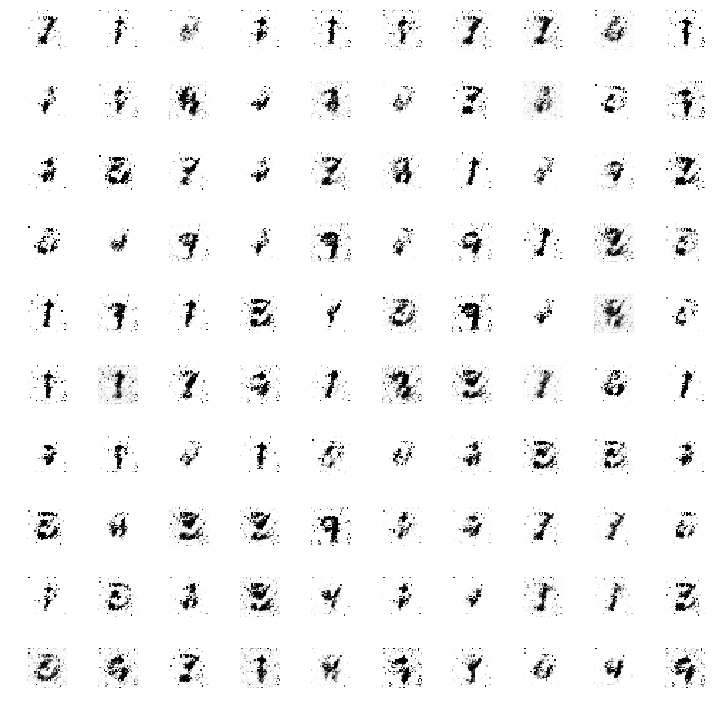

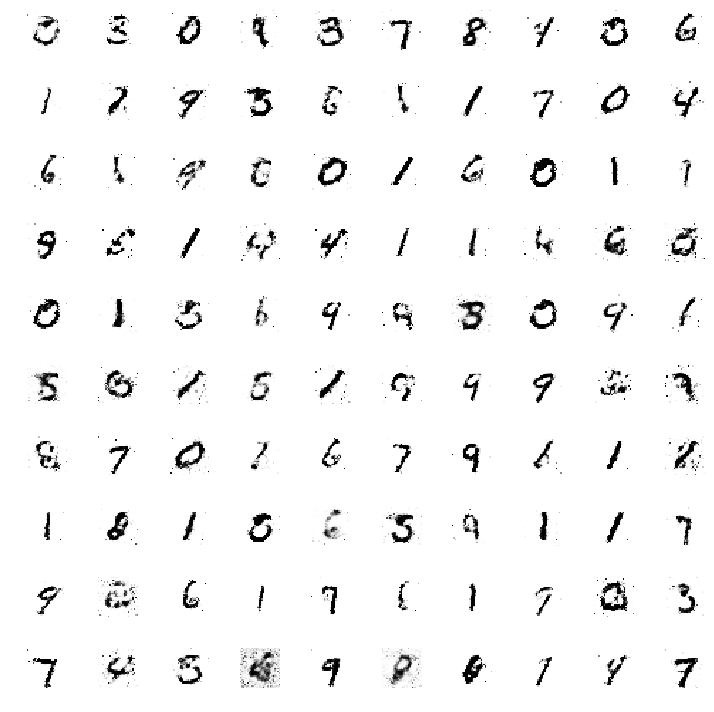

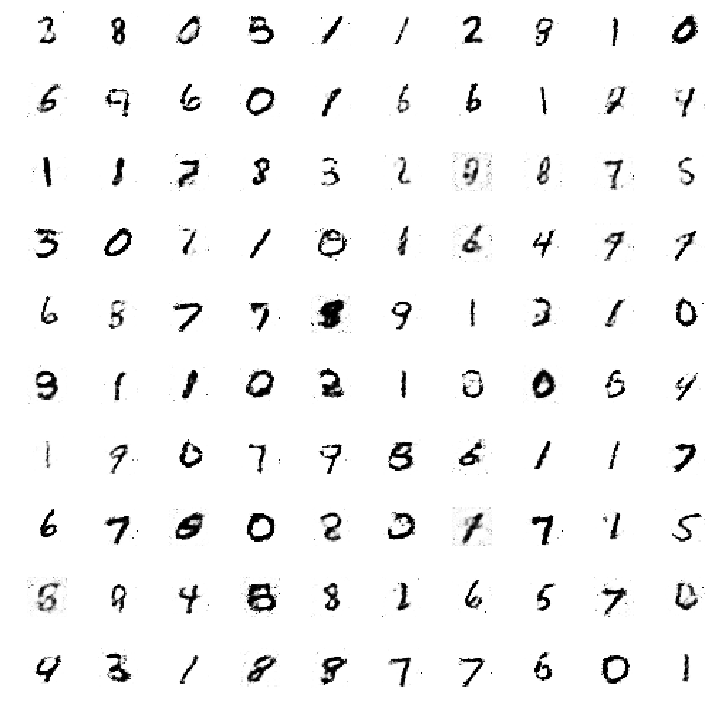

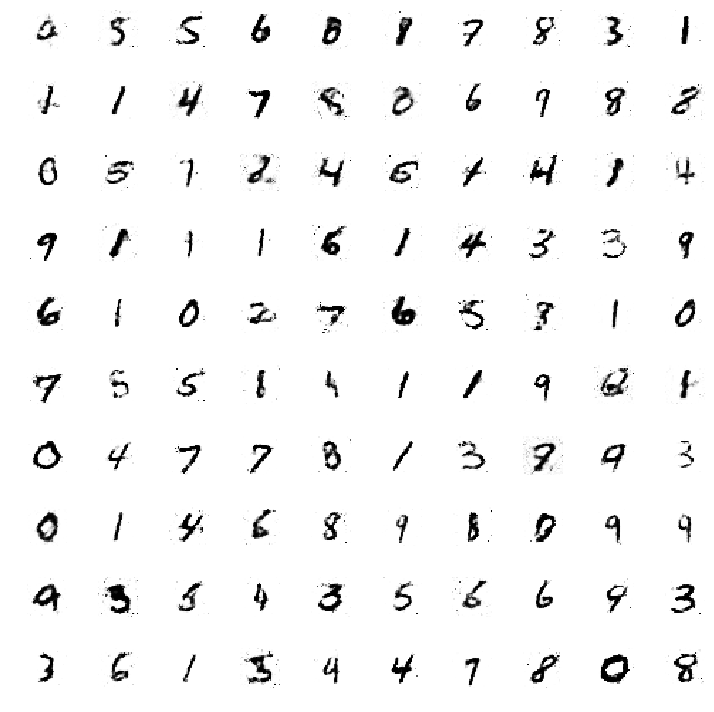

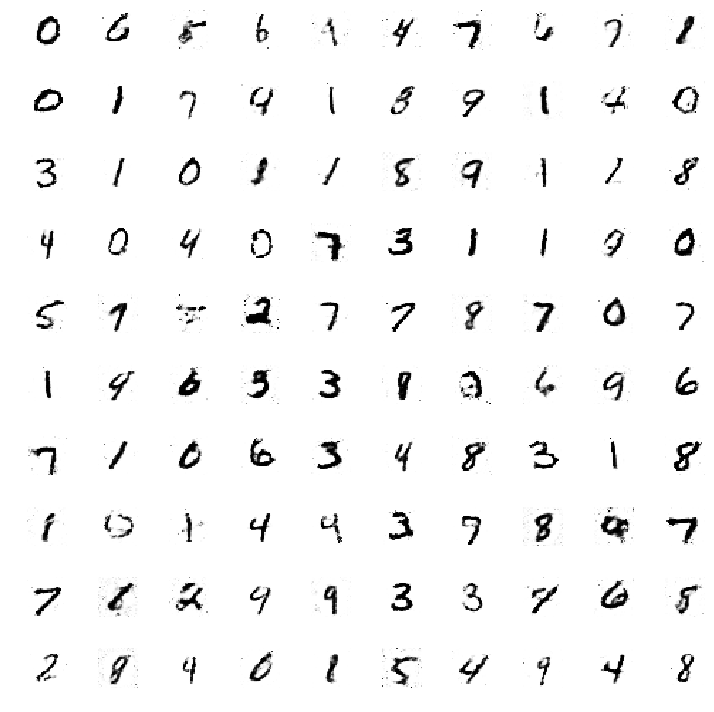

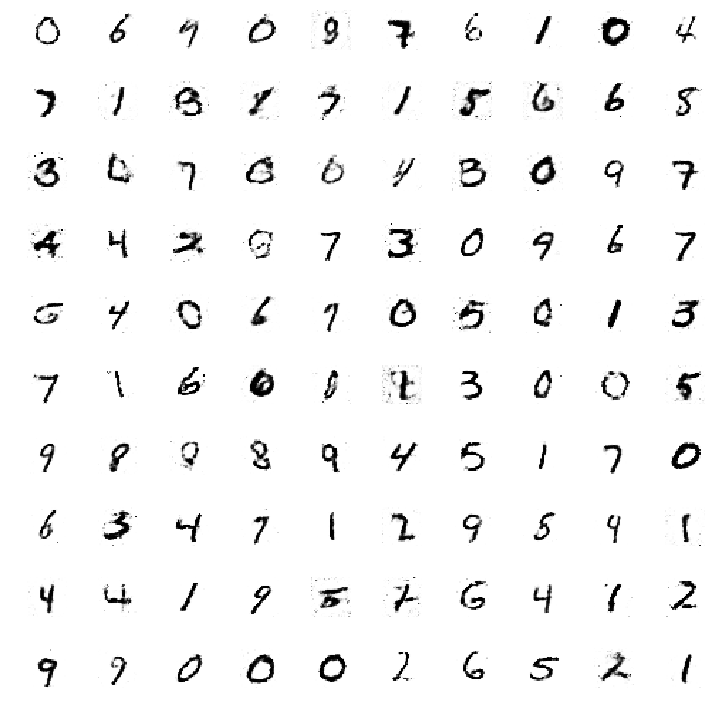

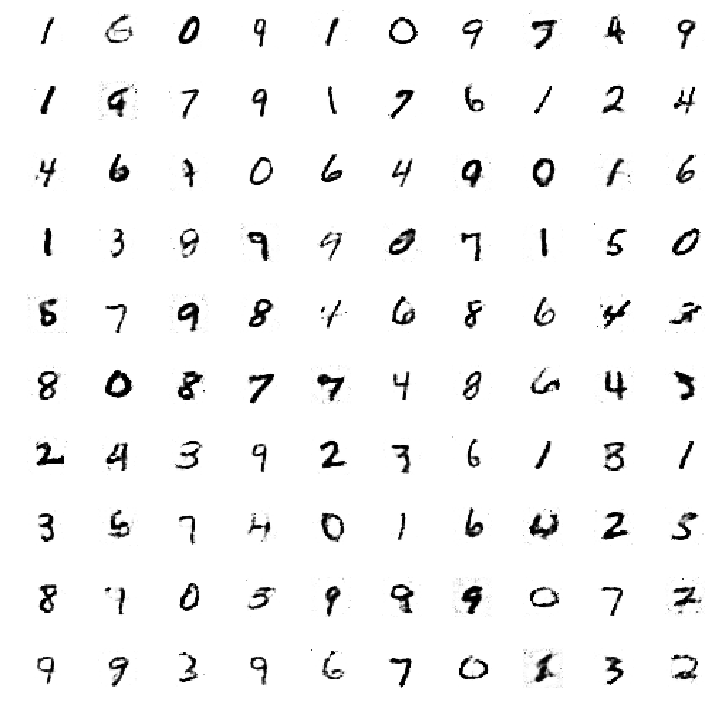

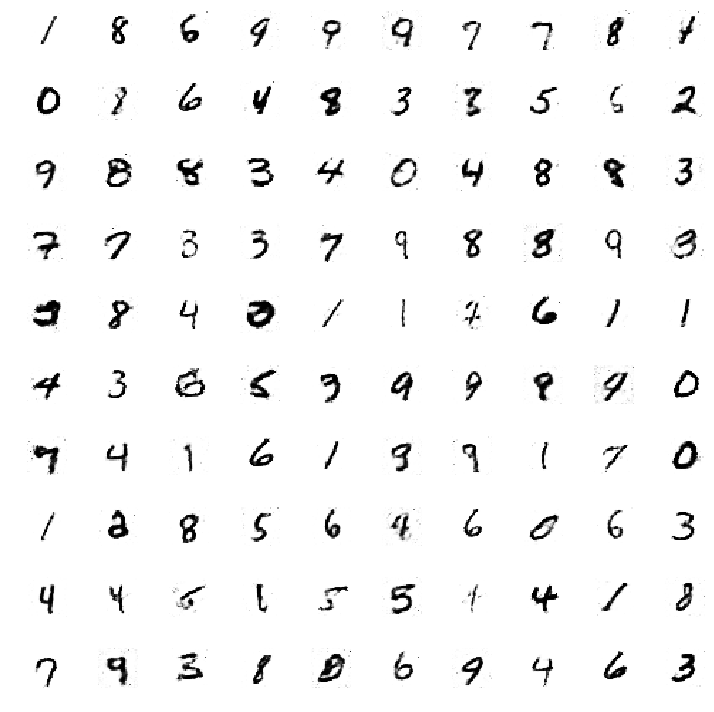

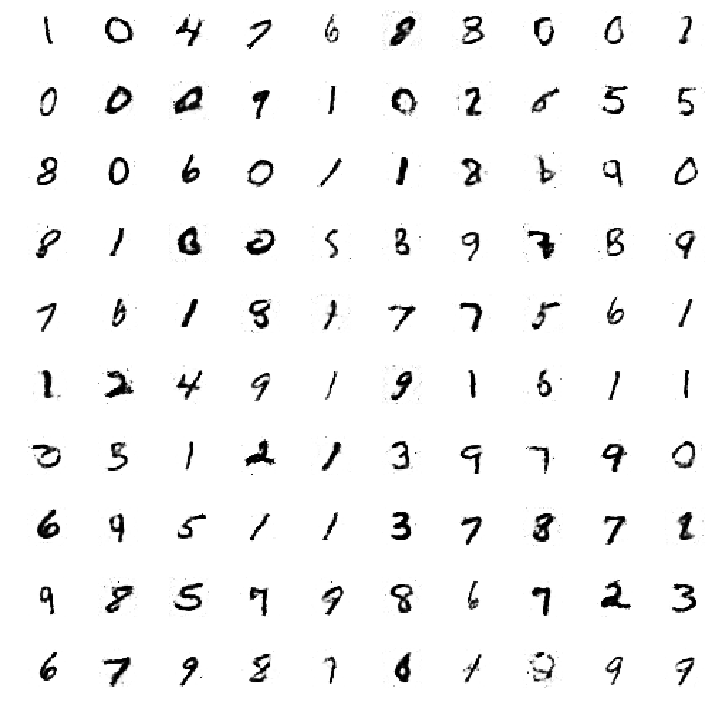

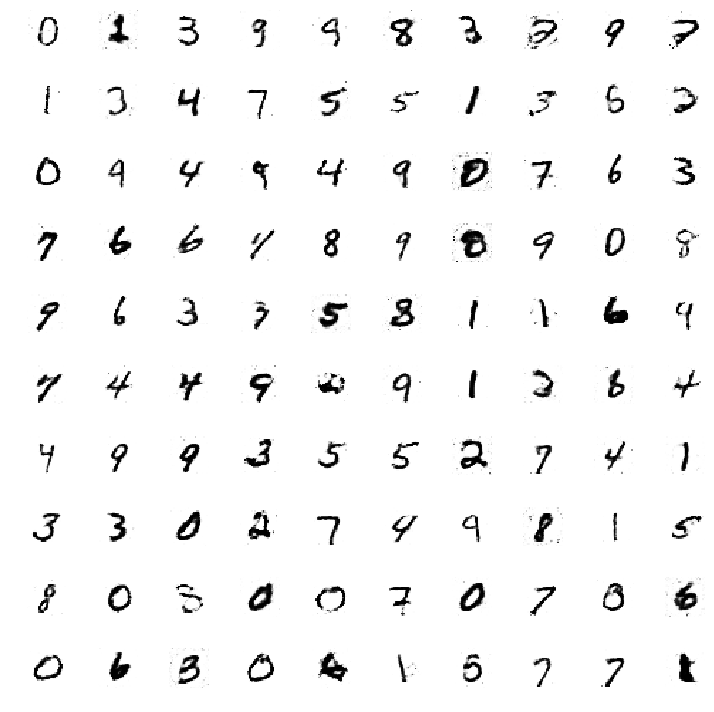

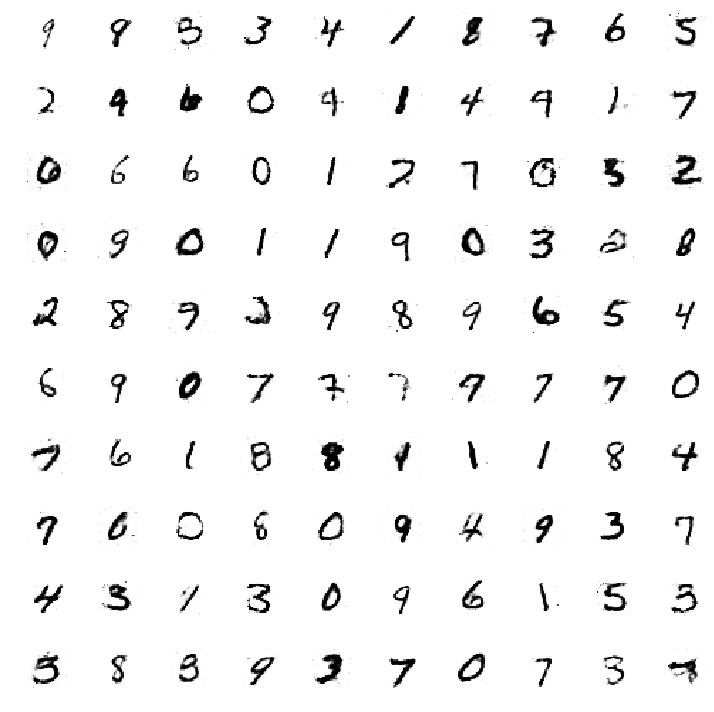

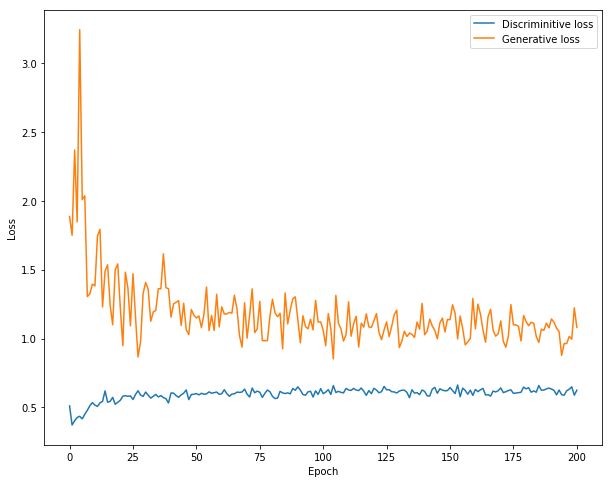

In [7]:

if __name__ == '__main__':
    train(200, 128)
    
    